# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
!pip install contractions
import contractions
import re
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
     |████████████████████████████████| 321 kB 377 kB/s 
     |████████████████████████████████| 283 kB 3.6 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=102922 sha256=83aaf80adaf0d782556d33fba92649a2bd42592cf479f3692a2e4c7cf03fbb02
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [2]:
train_data = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/train.txt', names=['text', 'emotion'], sep=';')
val_data = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/val.txt', names=['text', 'emotion'], sep=';')
test_data = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/test.txt', names=['text', 'emotion'], sep=';')
train_data.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


# Exploratory Data Analysis EDA

**Check for null values in train, val and test dataset**

In [3]:
data = {'Train Data': train_data, 'Validation Data': val_data, 'Test Data': test_data}
for temp in data:
    print(temp)
    print(data[temp].isnull().sum())
    print('*'*20)

Train Data
text       0
emotion    0
dtype: int64
********************
Validation Data
text       0
emotion    0
dtype: int64
********************
Test Data
text       0
emotion    0
dtype: int64
********************


**Class Distribution in Train, val and test dataset**

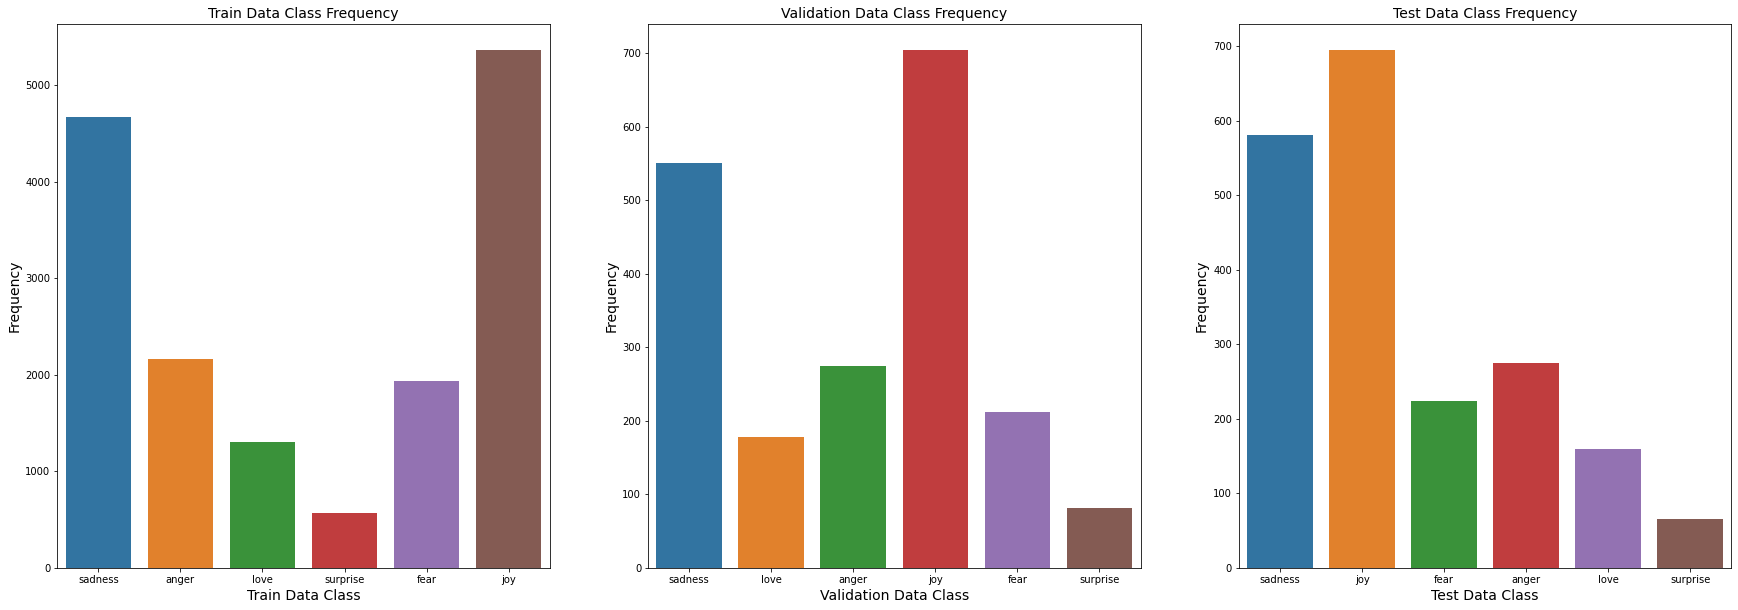

In [4]:
bar, ax = plt.subplots(1,3, figsize=(30, 10))
for index, temp in enumerate(data):
    sns.countplot(ax = ax[index],x = 'emotion', data = data[temp])
    ax[index].set_title(temp+' Class Frequency', size=14)
    ax[index].set_ylabel('Frequency', size=14)
    ax[index].set_xlabel(temp+' Class', size=14)

It is evident that dataset is highly imbalanced. "Joy" class has highest frequency  and 'Surprise' have least frequency in all three datasets.

**Word Cloud** to get most frequent words.

In [5]:
def plot_cloud(wordcloud, temp):
    plt.figure(figsize=(10, 10))
    plt.title(temp+' Word Cloud', size = 16)
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

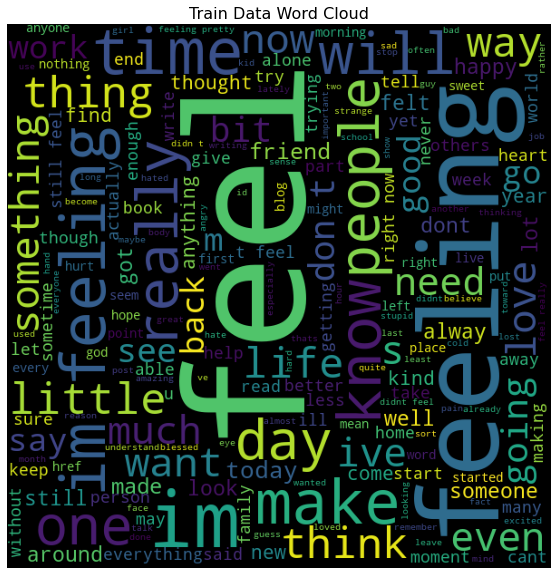

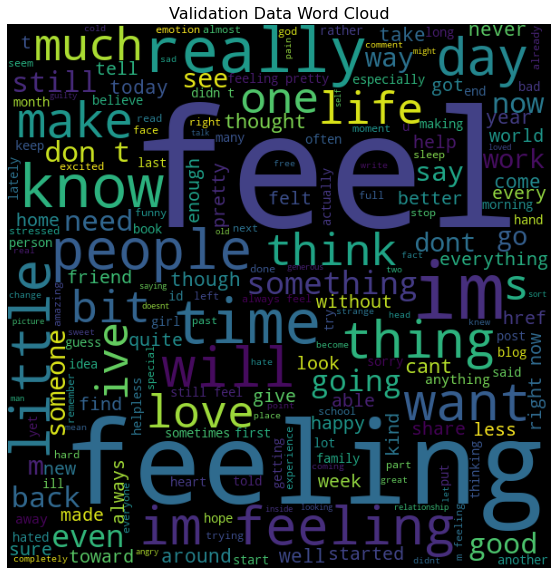

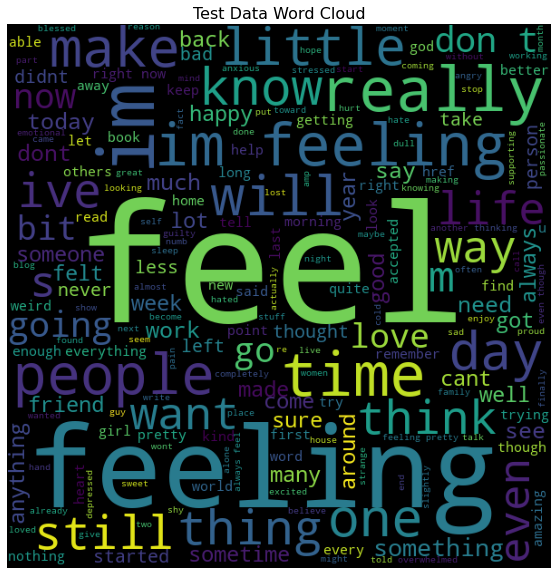

In [6]:
for temp in data:
    temp_text = ' '.join([sentence for sentence in data[temp].text])
    wordcloud = WordCloud(width = 600, height = 600).generate(temp_text)
    plot_cloud(wordcloud, temp)

# Pre-Processing

**Preprocessing includes:**
1. Removing stopwords (without removing negative words)
2. Expand Contractions
3. Lemmatization

**Note:** Negative words are removed from the set of stopwords as it makes "I am not happy" to "happy" after preprocessing. In short, it can change the semantic meaning of sentence and result into wrong training.

In [7]:
def preprocess(sentence):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    sentence = re.sub('[^A-z]', ' ', sentence)
    negative = ['not', 'neither', 'nor', 'but', 'however', 'although', 'nonetheless', 'despite', 'except',
                        'even though', 'yet']
    stop_words = [z for z in stop_words if z not in negative]
    preprocessed_tokens = [lemmatizer.lemmatize(contractions.fix(temp.lower())) for temp in sentence.split() if temp not in stop_words] #lemmatization
    return ' '.join([x for x in preprocessed_tokens]).strip()


In [8]:
train_data['text'] = train_data['text'].apply(lambda x: preprocess(x))
val_data['text'] = val_data['text'].apply(lambda x: preprocess(x))
test_data['text'] = test_data['text'].apply(lambda x: preprocess(x))

**Note:** As class imbalanced is evident, RandomOverSampler is used to add data(repetition) to all classes except highest frequency class.

In [9]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
train_x, train_y = ros.fit_resample(np.array(train_data['text']).reshape(-1, 1), np.array(train_data['emotion']).reshape(-1, 1))
train = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text', 'emotion'])

Applying OneHotEncoder on target of all dataset

In [10]:
from sklearn import preprocessing
le = preprocessing.OneHotEncoder()
y_train= le.fit_transform(np.array(train['emotion']).reshape(-1, 1)).toarray()
y_test= le.fit_transform(np.array(test_data['emotion']).reshape(-1, 1)).toarray()
y_val= le.fit_transform(np.array(val_data['emotion']).reshape(-1, 1)).toarray()

# Encoding

There is a very helpful function called encode_plus provided in the Tokenizer class. It can seamlessly perform the following operations:

* Tokenize the text and Add special tokens - [CLS] and [SEP]
* create input IDs
* Pad the sentences to a maximum length
* Create attention masks for the above PAD tokens

**Note:** RoBERTa uses byte-level Byte-Pair Encoding (BPE) in contrast to BERT’s character-level BPE.

In [11]:
from transformers import RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [12]:
def roberta_encode(data,maximum_length) :
  input_ids = []
  attention_masks = []
  

  for i in range(len(data.text)):
      encoded = tokenizer.encode_plus(
        
        data.text[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        
        return_attention_mask=True,
        
      )
      
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

In [13]:
max_len = max([len(x.split()) for x in train_data['text']])
train_input_ids,train_attention_masks = roberta_encode(train, max_len)
test_input_ids,test_attention_masks = roberta_encode(test_data, max_len)
val_input_ids,val_attention_masks = roberta_encode(val_data, max_len)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Create Model

**How RoBERTa is better than BERT ??**

Changes in Pre-Training:
* without NSP objective 
* with dynamic mask generation

Changes in Data:
* Trained on more data (16GB BERT vs 160GB RoBERTa)
* Trained on large batches

**Note:** Pre-requistics is to go through BERT

References:
* Bert: https://arxiv.org/pdf/1810.04805.pdf
* The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning): http://jalammar.github.io/illustrated-bert/
* The Illustrated Transformer: https://jalammar.github.io/illustrated-transformer/
* Attention Is All You Need: https://arxiv.org/pdf/1706.03762.pdf
* Query,key,value vector: https://stats.stackexchange.com/questions/421935/what-exactly-are-keys-queries-and-values-in-attention-mechanisms

In [14]:
def create_model(bert_model, max_len):
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]

    output = tf.keras.layers.Dense(6, activation='softmax')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
from transformers import TFRobertaModel
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [16]:
model = create_model(roberta_model, max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 43)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 43)]         0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124645632   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 6)            4614        tf_roberta_model[0][1]       

# Model Training

In [17]:
history = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_val), epochs=4,batch_size=100)

Epoch 1/4
322/322 [==============================] - 170s 484ms/step - loss: 1.0561 - accuracy: 0.5710 - val_loss: 0.2731 - val_accuracy: 0.9050
Epoch 2/4
322/322 [==============================] - 154s 479ms/step - loss: 0.1741 - accuracy: 0.9370 - val_loss: 0.2063 - val_accuracy: 0.9315
Epoch 3/4
322/322 [==============================] - 154s 478ms/step - loss: 0.1268 - accuracy: 0.9506 - val_loss: 0.1641 - val_accuracy: 0.9285
Epoch 4/4
322/322 [==============================] - 154s 478ms/step - loss: 0.1026 - accuracy: 0.9593 - val_loss: 0.1507 - val_accuracy: 0.9380


**Plotting Accuracy and Loss (Training and Validation)**

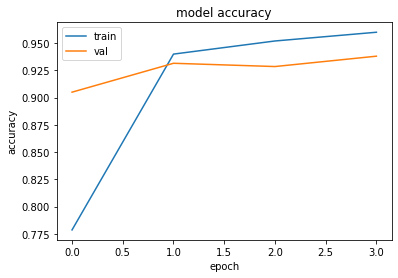

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

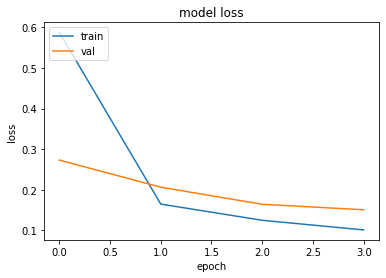

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**RoBERTa Model prediction on Test Data**

In [20]:
result = model.predict([test_input_ids,test_attention_masks])
y_pred = np.zeros_like(result)
y_pred[np.arange(len(result)), result.argmax(1)] = 1

**Accuracy and F1 Score of Model**

In [21]:
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy ', accuracy)
f1 = f1_score(y_test, y_pred, average = 'macro')
print('F1 Score :', f1)

Accuracy  0.927
F1 Score : 0.8916476230214956


In [22]:
# Save the weights
model.save_weights('my_checkpoint')

# Model Inference

In [23]:
def plot_result(result):
    sns.barplot(x = 'Category', y = 'Confidence', data = result)
    plt.xlabel('Categories', size=14)
    plt.ylabel('Confidence', size=14)
    plt.title('Emotion Classification', size=16)

In [24]:
def roberta_inference_encode(data,maximum_length) :
    input_ids = []
    attention_masks = []
  

  
    encoded = tokenizer.encode_plus(
    data,
    add_special_tokens=True,
    max_length=maximum_length,
    pad_to_max_length=True,

    return_attention_mask=True

    )

    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [25]:
def inference(text_sentence, max_len):
    preprocessed_text = preprocess(text_sentence)
    input_ids, attention_masks = roberta_inference_encode(preprocessed_text, maximum_length = max_len)
    model = create_model(roberta_model, 43)
    model.load_weights('my_checkpoint')
    result = model.predict([input_ids, attention_masks])
    #le.categories_[0] = ['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']
    result = pd.DataFrame(dict(zip(list(le.categories_[0]), [round(x*100, 2)for x in result[0]])).items(), columns = ['Category', 'Confidence'])
    plot_result(result)
    return result

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


   Category  Confidence
0     anger       13.87
1      fear        1.17
2       joy        1.03
3      love        0.01
4   sadness       83.91
5  surprise        0.01


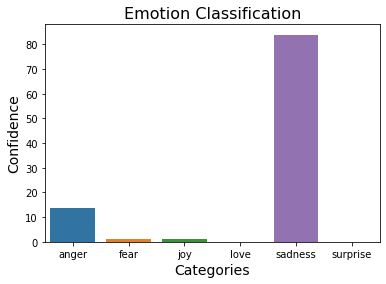

In [26]:
result = inference("I am unhappy", max_len)
print(result)